In [73]:
import os
import sys
import json
import geopandas as gpd
import rasterio
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from shapely.geometry import Point
from dataclasses import dataclass
from geopy.geocoders import Nominatim
from sklearn.neighbors import BallTree
from shapely import MultiPolygon
from shapely import Polygon
import numpy as np
import seaborn as sns
import datetime
from funcy import group_by
import pycountry_convert as pc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
@dataclass
class Datacenter:
    name: str
    location: Point
    local: bool
    edge: bool
    launched: str

    def dateTime(self):
        if self.launched:
            return datetime.datetime.strptime(self.launched, "%m-%d-%Y").date()
        return None
        
    def region(self):
        return not (self.local or self.edge)

def loadDatacenters():
    with open('./data/available_cities.json') as f:
        available_cities = json.load(f)
        return [Datacenter(a['name'], Point(a['longitude'], a['latitude']), a['local'], a['edge'], a.get('launched')) for a in available_cities]

In [12]:
sns.set_theme()
sns.set_style("whitegrid")

pop_data_tract = './data/ACS_Population_Variables_-_Boundaries/Tract_2.csv'
income_data_tract = './data/ACS_Median_Household_Income_Variables_-_Boundaries/Tract_2.csv'

In [13]:
import matplotlib.ticker as mtick

def style_graph_cdf(ax, xlabel='Distance (km)'):
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel('% of Tracts', size=24)
    ax.set_xlabel(xlabel, size=24)
    ax.tick_params(axis='both', which='major', labelsize=18)

In [30]:
census_tract = None
for i in range(1, 57):
    # There is no file for these numbers
    if i == 3 or i == 7 or i == 14 or i == 43 or i == 52:
        continue

    url = f"https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_{i:02d}_tract.zip"
    if census_tract is None:
        census_tract = gpd.read_file(url)
    else:
        census_tract = pd.concat([census_tract, gpd.read_file(url)])

In [31]:
census_tract['fips_code'] = (census_tract['STATEFP'] + census_tract['COUNTYFP'] + census_tract['TRACTCE']).astype(int)
census_tract = census_tract[['fips_code', 'INTPTLAT', 'INTPTLON', 'NAMELSAD', 'geometry', 'STATEFP']]

In [32]:
income_key = 'Median Household Income in past 12 months (inflation-adjusted dollars to last year of 5-year range)'
id_key = 'Geographic Identifier - FIPS Code'

pop_data = pop_data_tract
pop_df = pd.read_csv(pop_data)
pop_df = pop_df[['Total Population', id_key]]

income_data = income_data_tract
income_df = pd.read_csv(income_data)
income_df = income_df[[income_key, id_key]]
income_df.head()

merged_df = pd.merge(pop_df, income_df, left_on=id_key, right_on=id_key)

merged_geo_df = pd.merge(merged_df, census_tract, left_on=id_key, right_on='fips_code')
# Filter out Alaska, Hawaii, Puerto Rico
merged_geo_df = merged_geo_df[~merged_geo_df['STATEFP'].isin(['02', '15', '72'])]
population = merged_geo_df['Total Population']
income = merged_geo_df[income_key]
lat = merged_geo_df['INTPTLAT']
lon = merged_geo_df['INTPTLON']
points = [Point(float(a[1]), float(a[0])) for a in zip(lat, lon)]

# Percentile Ratios

9.083860692406072
22.644212872947048
26.315192300325748


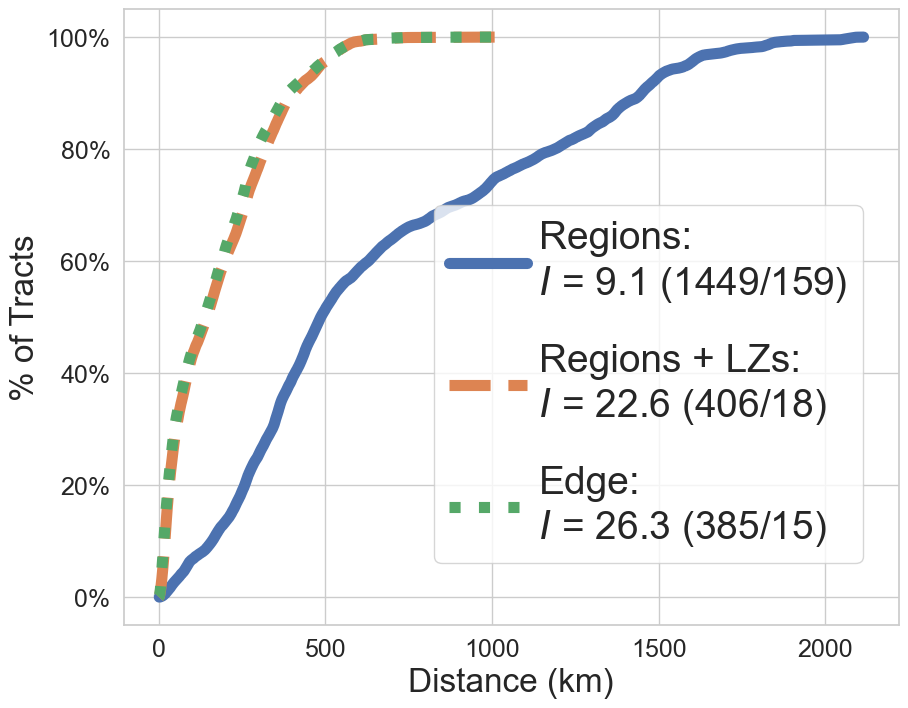

In [81]:
def addMinDistances(inputDF, regions):

    unit_sphere_to_km = 6371

    # The region json uses x for longitude, y for latitude
    lat = np.deg2rad([c.y for c in regions])
    lng = np.deg2rad([c.x for c in regions])
    all_locations_dataframe = pd.DataFrame(list(zip(lat, lng)), columns = ['lat', 'lng'])

    all_locations_bt = BallTree(all_locations_dataframe[['lat', 'lng']].values, metric='haversine')

    if 'INTPTLAT' in inputDF:
        lat = np.deg2rad(inputDF['INTPTLAT'].astype(float))
        lng = np.deg2rad(inputDF['INTPTLON'].astype(float))
    else:
        centroids = inputDF.geometry
        if isinstance(list(inputDF.geometry)[0], MultiPolygon):
            centroids = inputDF.geometry.centroid
        if isinstance(list(inputDF.geometry)[0], Polygon):
            centroids = inputDF.geometry.centroid

        lat = np.deg2rad([c.y for c in centroids])
        lng = np.deg2rad([c.x for c in centroids])
    points_dataframe = pd.DataFrame(list(zip(lat, lng)), columns = ['lat', 'lng'])
    distances, index = all_locations_bt.query(points_dataframe[['lat', 'lng']].values, k=len(regions))
    distances = [[l * unit_sphere_to_km for l in d] for d in distances]
    inputDF['distances'] = distances
    return inputDF

def percentile(p, x, cum_percent):
    for i in range(0, len(cum_percent)):
        if cum_percent[i] >= p:
            return x[i]

def plotDistances(gdf, locations, label, linestyle, ax):
    population_distances = addMinDistances(gdf, locations)
    population_distances['min_distance'] = [min(d) for d in population_distances.distances]
    with_pop_df = population_distances[population_distances['Total Population'] > 0]
    total_pop = sum(with_pop_df['Total Population'])
    with_pop_df = with_pop_df.sort_values('min_distance', inplace=False)
    dist = list(with_pop_df['min_distance'])
    percentages = np.cumsum(list(with_pop_df['Total Population'])) / total_pop
    p90 = percentile(0.9, dist, percentages)
    p10 = percentile(0.1, dist, percentages)
    percentile_diff = p90 / p10
    if label:
        ax.plot(dist, percentages, linewidth=8, label="%s:\n$\it{I}$ = %2.1f (%.0f/%.0f)" % (label, percentile_diff, p90, p10), linestyle=linestyle)
    return [dist, percentages]

datacenters = loadDatacenters()
region_locations = [d.location for d in datacenters if d.region()]

fig, ax = plt.subplots(figsize=(10, 8))
a, b = plotDistances(merged_geo_df, region_locations, "Regions", '-', ax)
print(percentile(0.9, a, b) / percentile(0.1, a, b))
a, b = plotDistances(merged_geo_df, [d.location for d in datacenters if d.local or d.region()], "Regions + LZs", '--', ax)
print(percentile(0.9, a, b) / percentile(0.1, a, b))
a, b = plotDistances(merged_geo_df, [d.location for d in datacenters], "Edge", 'dotted', ax)
print(percentile(0.9, a, b) / percentile(0.1, a, b))
style_graph_cdf(ax)
ax.legend(
    labelspacing=1,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc=(0.4, 0.1),
)
fig.savefig('images/us_percentiles.png', bbox_inches='tight', dpi=300)

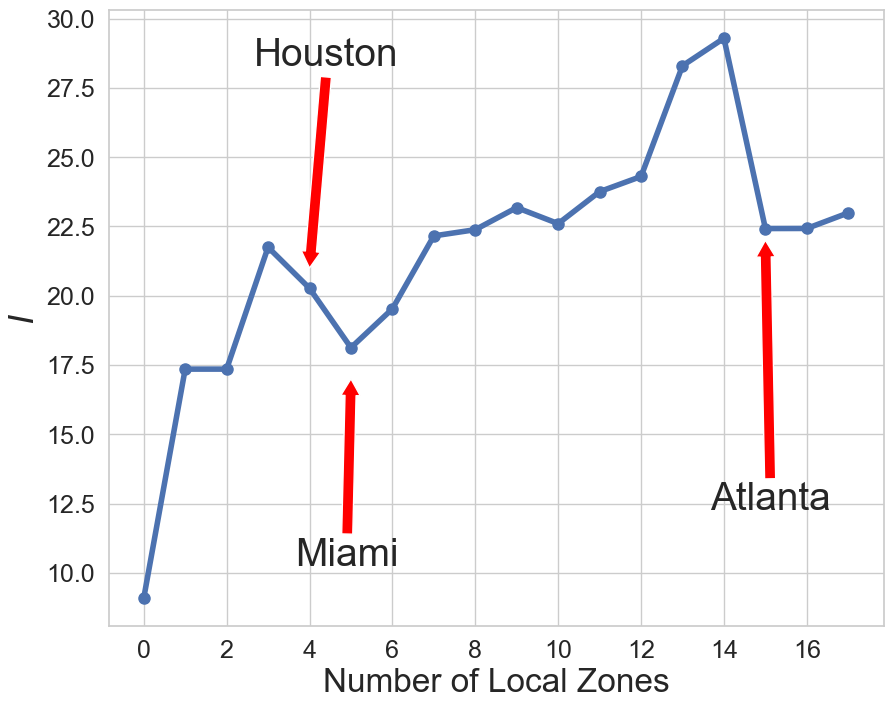

In [45]:
from matplotlib.ticker import MaxNLocator

datacenters = loadDatacenters()
datacenters = [d for d in datacenters if d.dateTime() != None]
datacenters.sort(key=lambda x: x.dateTime())
start_index = 0
for d in datacenters:
    if d.local:
        break
    else:
        start_index += 1

starting_datacenters = datacenters[0:start_index]

percentile_ratio = []
last_length = -1
for i in range(start_index, len(datacenters)+1):
    # Start with all datacenters (regions included) but only add local zones, this makes sure only US locations are added
    new_local_zones = [d for d in datacenters[0:i] if d.local]
    if last_length == len(new_local_zones):
        # This index was a region, skip it
        continue

    # First local zone outside of US, exit here because the rest of them will have no change
    if len(new_local_zones) > 0 and new_local_zones[-1].name == 'Delhi, India':
        break

    last_length = len(new_local_zones)
    a, b = plotDistances(merged_geo_df, [d.location for d in starting_datacenters] + [d.location for d in new_local_zones], None, '-', None)
    percentile_ratio.append(percentile(0.9, a, b) / percentile(0.1, a, b))
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(0, len(percentile_ratio)), percentile_ratio, '-o', linewidth=4, markersize=8)
ax.set_ylabel('$\it{I}$', size=24)
ax.set_xlabel('Number of Local Zones', size=24)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=18)

ax.annotate('Atlanta',
            xy=(15, 22), xycoords='data', fontsize='28',
            xytext=(-40, -200), textcoords='offset points',
            arrowprops=dict(facecolor='red', width=8, headwidth=14),
            horizontalalignment='left', verticalalignment='bottom')

ax.annotate('Houston',
            xy=(4, 21), xycoords='data', fontsize='28',
            xytext=(-40, 140), textcoords='offset points',
            arrowprops=dict(facecolor='red', width=8, headwidth=14),
            horizontalalignment='left', verticalalignment='bottom')

ax.annotate('Miami',
            xy=(5, 17), xycoords='data', fontsize='28',
            xytext=(-40, -140), textcoords='offset points',
            arrowprops=dict(facecolor='red', width=8, headwidth=14),
            horizontalalignment='left', verticalalignment='bottom')

fig.savefig('images/percentiles_over_time.png', bbox_inches='tight', dpi=300)

## Global

In [53]:
def rasterio_to_gdf(src):
    crs = src.crs
    xmin, ymax = np.around(src.xy(0.00, 0.00), 9)
    xmax, ymin = np.around(src.xy(src.height-1, src.width-1), 9)
    x = np.linspace(xmin, xmax, src.width)
    y = np.linspace(ymax, ymin, src.height)

    xs, ys = np.meshgrid(x, y)
    zs = src.read(1)

    mask = src.read_masks(1) > 0
    xs, ys, zs = xs[mask], ys[mask], zs[mask]

    data = {"X": pd.Series(xs.ravel()),
        "Y": pd.Series(ys.ravel()),
        "B1": pd.Series(zs.ravel())}

    df = pd.DataFrame(data=data)
    geometry = gpd.points_from_xy(df.X, df.Y)
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry), df.X, df.Y

def ckdnearest(gdA, gdB):
    # Assuming input is already using points for geometry column. Otherwise it would need to use ".centroid"
    centroids = gdB.geometry
    lat = np.deg2rad([c.y for c in centroids])
    lng = np.deg2rad([c.x for c in centroids])
    locations = pd.DataFrame(list(zip(lat, lng)), columns = ['lat', 'lng'])

    bt = BallTree(locations[['lat', 'lng']].values, metric='haversine')

    centroids = gdA.geometry
    if isinstance(list(gdA.geometry)[0], MultiPolygon):
        centroids = gdA.geometry.centroid
    if isinstance(list(gdA.geometry)[0], Polygon):
        centroids = gdA.geometry.centroid

    lat = np.deg2rad([c.y for c in centroids])
    lng = np.deg2rad([c.x for c in centroids])
    locations = pd.DataFrame(list(zip(lat, lng)), columns = ['lat', 'lng'])
    dist, idx = bt.query(locations[['lat', 'lng']].values, k=1)

    gdB_nearest = gdB.iloc[[x[0] for x in idx]].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series([x[0] * 6371 for x in dist], name='dist')
        ], 
        axis=1)

    return gdf

In [49]:
raster = rasterio.open('./data/gpw_v4_population_count_rev11_2020_15_min.tif')
gdf, xs, ys = rasterio_to_gdf(raster)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from geopandas.tools import sjoin
gdf_continent = sjoin(gdf, world, how='left')

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/13653005.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [50]:
continents = ['oc', 'af', 'eu', 'na', 'sa', 'as']

def continentToName(continent):
    if continent=='oc':
        return 'Oceania'
    if continent=='af':
        return 'Africa'
    if continent=='eu':
        return 'Europe'
    if continent=='na':
        return 'North America'
    if continent=='sa':
        return 'South America'
    if continent=='as':
        return 'Asia'

In [51]:
def plotGeoDFDistances(gdf, locations, label):
    datacenter_locations = gpd.GeoDataFrame(geometry=locations)
    datacenter_locations.crs = 'EPSG:4326'
    population_distances = ckdnearest(gdf, datacenter_locations)
    with_pop_df = population_distances[population_distances['B1'] > 0]
    total_pop = sum(with_pop_df['B1'])
    with_pop_df = with_pop_df.sort_values('dist', inplace=False)
    dist = list(with_pop_df['dist'])
    percentages = np.cumsum(list(with_pop_df['B1'])) / total_pop
    if label:
        plt.plot(dist, percentages, label=label)
        plt.xlim(0, 7000)
    return [dist, percentages]

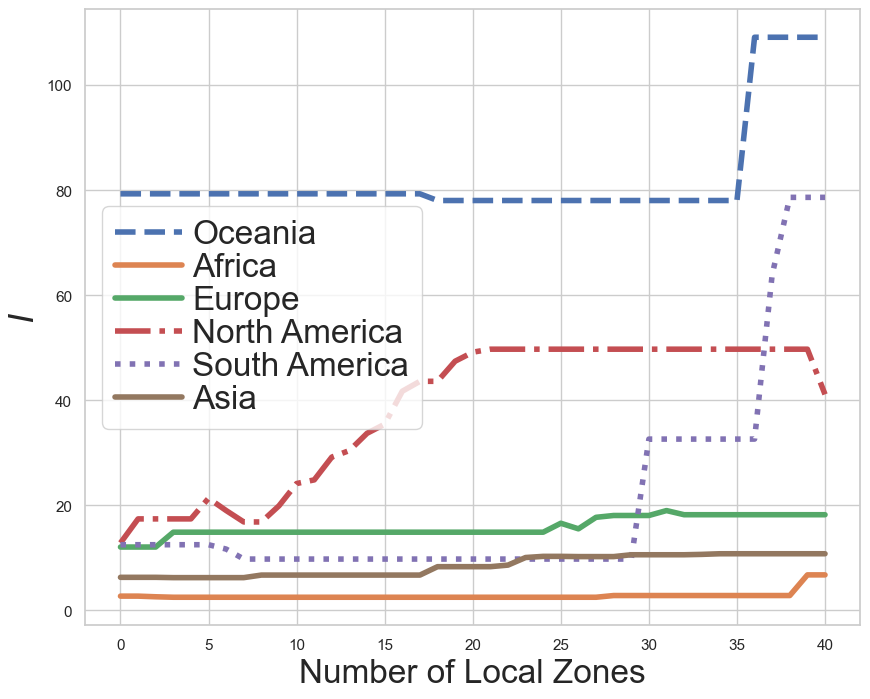

In [56]:
datacenters = loadDatacenters()
datacenters = [d for d in datacenters if d.dateTime() != None]
datacenters.sort(key=lambda x: x.dateTime())
start_index = 0
for d in datacenters:
    if d.local:
        break
    else:
        start_index += 1
        
def continentToStyle(continent):
    if continent == 'oc':
        return '--'
    if continent == 'na':
        return '-.'
    if continent == 'sa':
        return ':'
    return '-'

fig, ax = plt.subplots(figsize=(10, 8))

for continent in continents:
    this_gdf = gdf_continent[gdf_continent['continent'] == continentToName(continent)]
    results = []
    for i in range(start_index, len(datacenters)+1):
        continent_all_results = plotGeoDFDistances(this_gdf, [d.location for d in datacenters[0:i]], None)
        results.append(percentile(0.9, continent_all_results[0], continent_all_results[1]) / percentile(0.1, continent_all_results[0], continent_all_results[1]))
    ax.plot(np.arange(0, len(results)), results, linewidth=4, label=continentToName(continent), linestyle=continentToStyle(continent))
ax.set_ylabel('$\it{I}$', size=24)
ax.set_xlabel('Number of Local Zones', size=24)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="24",
    loc="best",
)
fig.savefig('images/global_percentiles_time.png', bbox_inches='tight', dpi=300)

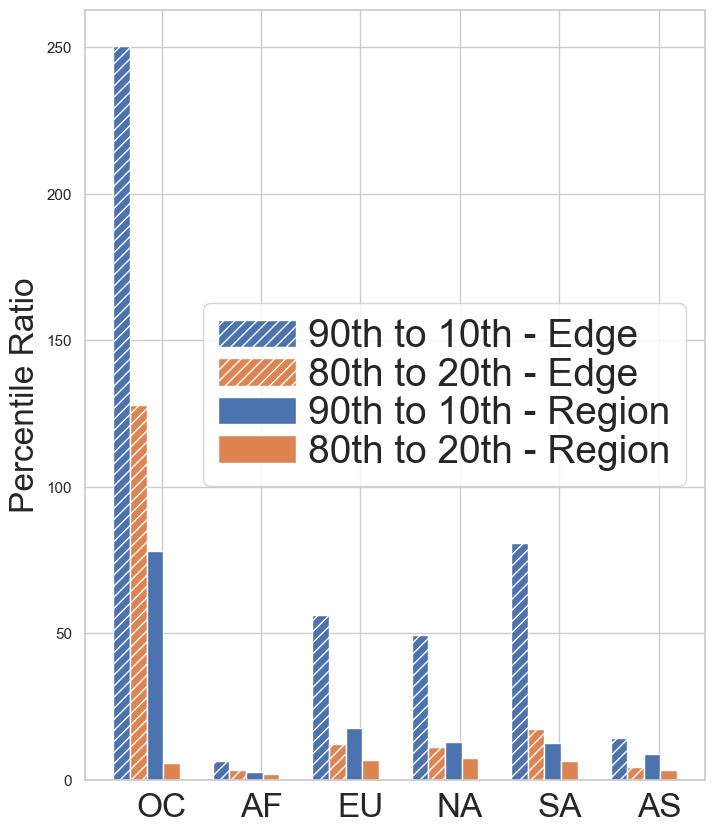

In [59]:
datacenters = loadDatacenters()
all_locations = [d.location for d in datacenters]

edge_10 = []
region_10 = []
edge_20 = []
region_20 = []
for continent in continents:
    this_gdf = gdf_continent[gdf_continent['continent'] == continentToName(continent)]
    continent_all_results = plotGeoDFDistances(this_gdf, all_locations, None)
    edge_p90 = percentile(0.9, continent_all_results[0], continent_all_results[1])
    edge_p10 = percentile(0.1, continent_all_results[0], continent_all_results[1])
    edge_10.append(edge_p90 / edge_p10)
    edge_20.append(percentile(0.8, continent_all_results[0], continent_all_results[1]) / percentile(0.2, continent_all_results[0], continent_all_results[1]))

    continent_region_results = plotGeoDFDistances(this_gdf, region_locations, None)
    region_p90 = percentile(0.9, continent_region_results[0], continent_region_results[1])
    region_p10 = percentile(0.1, continent_region_results[0], continent_region_results[1])
    region_10.append(region_p90 / region_p10)
    region_20.append(percentile(0.8, continent_region_results[0], continent_region_results[1]) / percentile(0.2, continent_region_results[0], continent_region_results[1]))

fig, ax = plt.subplots(figsize=(8, 10))

x = np.arange(len(continents))
width = 1
count=6
colors = sns.color_palette()
rects1 = ax.bar(x - 3*width/count, edge_10, width/count, label='90th to 10th - Edge', hatch='///', color=colors[0])
rects1 = ax.bar(x - 2*width/count, edge_20, width/count, label='80th to 20th - Edge', hatch='///', color=colors[1])
rects2 = ax.bar(x - width/count, region_10, width/count, label='90th to 10th - Region', color=colors[0])
rects2 = ax.bar(x, region_20, width/count, label='80th to 20th - Region', color=colors[1])

# rects2 = ax.barh(x + width/count, local_10, width/count, label='90th to 10th - Local')
# rects2 = ax.barh(x + 2*width/count, local_20, width/count, label='80th to 20th - Local')
ax.set_xticks([p-0.1 for p in x], [c.upper() for c in continents], fontsize="24")
ax.set_ylabel('Percentile Ratio', size='24')
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    loc="center right",
    fontsize="28",
)
fig.savefig('images/distance_gap.png', bbox_inches='tight', dpi=300)

# Concentration Index

In [66]:
def concentration_index(p, l):
    result = 0
    for i in np.arange(len(p) - 2):
        result += p[i]*l[i+1] - p[i+1]*l[i]
    return result

def fast_concentration_health(distance, max_distance):
    if distance < max_distance:
        return 1
    return 0

def fast_concentration_index(inputDF, datacenter_locations, label, ax=None, linestyle = '-'):
    df_with_distances = addMinDistances(inputDF, datacenter_locations)
    population = df_with_distances['Total Population']
    income = df_with_distances[income_key]
    health_indicator = [sum([fast_concentration_health(d, 88) for d in distances])*p for (distances, p) in zip(df_with_distances['distances'], population)]

    ci_points = [[a[0], a[1], a[2]] for a in list(zip(population, income, health_indicator)) if not math.isnan(a[1])]
    ci_points = sorted(ci_points, key=lambda x:x[1])
    x = np.cumsum([p[0] for p in ci_points])
    y = np.cumsum([p[2] for p in ci_points])
    x = x / x[-1]
    y = y / y[-1]
    ci = concentration_index(x, y)
    if label:
        ax.plot(x, y, label="%s: CI = %2.2f" % (label, ci), linewidth=4, linestyle=linestyle)
    return ci

0.4118530820041977
0.21335418926401276
0.23136423788281474


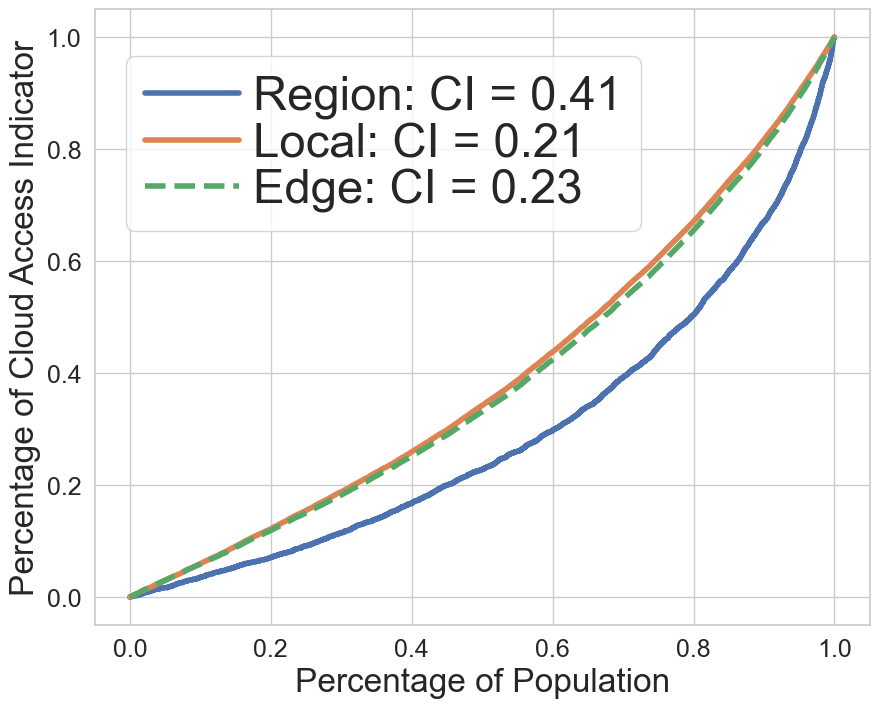

In [72]:
datacenters = loadDatacenters()
region_locations = [d.location for d in datacenters if d.region()]
local_locations = [d.location for d in datacenters if d.local]
non_edge_names = [d.name for d in datacenters if not d.edge]
edge_locations = [d.location for d in datacenters if d.edge and not d.name in non_edge_names]


fig, ax = plt.subplots(figsize=(10, 8))
print(fast_concentration_index(merged_geo_df, region_locations, 'Region', ax))
print(fast_concentration_index(merged_geo_df, region_locations + local_locations, 'Local', ax))
print(fast_concentration_index(merged_geo_df, region_locations + local_locations + edge_locations, 'Edge', ax, '--'))
ax.set_ylabel('Percentage of Cloud Access Indicator', size=24)
ax.set_xlabel('Percentage of Population', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="34",
    loc=(0.04, 0.64),
)
fig.savefig('images/concentration_curves_88.png', bbox_inches='tight', dpi=300)

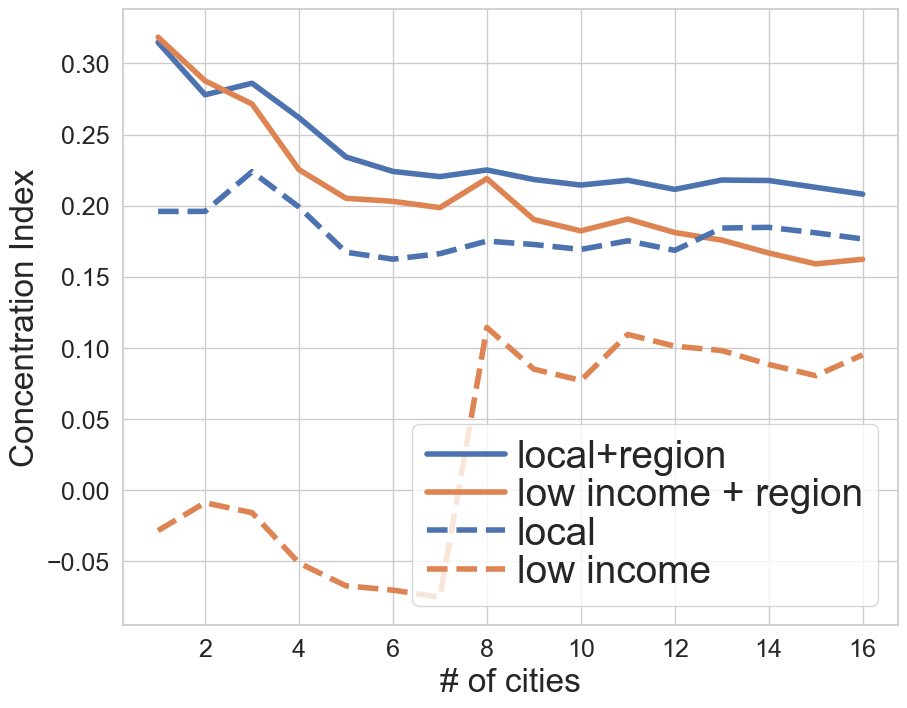

In [74]:
geolocator = Nominatim(user_agent='myapplication')

def locationFor(name):
    location = geolocator.geocode(name)
    return Point(location.longitude, location.latitude)

# Low concentration index with only the lowest income of the top 50 cities: https://www.neoch.org/top-poorest-cities-in-us
low_income_locations = [
    locationFor('Detroit, Michigan'),
    locationFor('St. Louis, Missouri'),
    locationFor('Rochester, New York'),
    locationFor('Cleveland, Ohio'),
    locationFor('Birmingham, Alabama'),
    locationFor('San Bernardino, CA'),
    locationFor('Laredo, Texas'),
    locationFor('Newark, NJ'),
    locationFor('Miami, FL'),
    locationFor('Buffalo, NY'),
    locationFor('Toledo, NJ'),
    locationFor('Cincinnati, OH'),
    locationFor('Milwaukee, WI'),
    locationFor('New Orleans, LA'),
    locationFor('Fresno, CA'),
    locationFor('Philadelphia, PA'),
]
low_income_indecies = []
for i in range(1, len(low_income_locations)+1):
    low_income_indecies.append(fast_concentration_index(merged_geo_df, low_income_locations[:i], None))
    
low_income_region_indecies = []
for i in range(1, len(low_income_locations)+1):
    low_income_region_indecies.append(fast_concentration_index(merged_geo_df, region_locations + low_income_locations[:i], None))

local_zones = [d for d in loadDatacenters() if d.local and d.launched]
local_zones.sort(key=lambda x: x.dateTime())
local_indecies = []
for i in range(1, 17):
    local_indecies.append(fast_concentration_index(merged_geo_df, [d.location for d in local_zones[:i]], None))

local_indecies_and_regions = []
for i in range(1, 17):
    local_indecies_and_regions.append(fast_concentration_index(merged_geo_df, region_locations + [d.location for d in local_zones[:i]], None))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(1, 17), local_indecies_and_regions, label='local+region', linewidth=4, color=sns.color_palette()[0])
ax.plot(range(1, 17), low_income_region_indecies, label='low income + region', linewidth=4, color=sns.color_palette()[1])
ax.plot(range(1, 17), local_indecies, label='local', linestyle='dashed', linewidth=4, color=sns.color_palette()[0])
ax.plot(range(1, 17), low_income_indecies, label='low income', linestyle='dashed', linewidth=4, color=sns.color_palette()[1])
ax.set_xlabel('# of cities', size=24)
ax.set_ylabel('Concentration Index', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc="lower right",
)
fig.savefig('images/concentration_index_88.png', bbox_inches='tight', dpi=300)

## Global

In [83]:
def concentration_index_from_df(df_with_distances, max_distance, label=None, ax=None, linestyle=None):
    df_with_distances = df_with_distances[df_with_distances['population'].notna()].copy()
    population = df_with_distances['population']
    df_with_distances['health_indicator'] = [sum([fast_concentration_health(d, max_distance) for d in distances])*p for (distances, p) in zip(df_with_distances['distances'], population)]
    income = df_with_distances['light_mean']
    health_indicator = df_with_distances['health_indicator']
    ci_points = [[a[0], a[1], a[2]] for a in list(zip(population, income, health_indicator)) if not math.isnan(a[1])]
    ci_points = sorted(ci_points, key=lambda x:x[1])
    x = np.cumsum([p[0] for p in ci_points])
    y = np.cumsum([p[2] for p in ci_points])
    if y[-1] == 0:
        return float("NaN")
    else:            
        x = x / x[-1]
        y = y / y[-1]
        if label:
            ax.plot(x, y, linewidth=4, label=label, linestyle=linestyle)
        return concentration_index(x, y)

In [84]:
from geopandas.tools import sjoin
from rasterstats import zonal_stats

def gdf_concentration(pop_raster, lights_raster, selected_admin_data):
    affine = pop_raster.transform
    ndval = pop_raster.nodatavals[0]
    array = pop_raster.read(1)
    df_zonal_stats = pd.DataFrame(
        zonal_stats(
            selected_admin_data,
            array,
            nodata=ndval,
            affine=affine,
            stats=['sum']))
    selected_admin_data['population'] = list(df_zonal_stats['sum'])
    
    affine = lights_raster.transform
    ndval = lights_raster.nodatavals[0] or 0
    array = lights_raster.read(1)
    df_zonal_stats = pd.DataFrame(
        zonal_stats(
            selected_admin_data,
            array,
            nodata=ndval,
            affine=affine,
            stats=['median', 'sum', 'mean']))
    selected_admin_data['light_sum'] = list(df_zonal_stats['sum'])
    selected_admin_data['light_median'] = list(df_zonal_stats['median'])
    selected_admin_data['light_mean'] = list(df_zonal_stats['mean'])
    return selected_admin_data

admin_data = gpd.read_file("data/gadm_410-levels.gpkg", layer='ADM_2')
pop_raster = rasterio.open('./data/gpw_v4_population_count_rev11_2020_15_min.tif')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

lights_pop_gdf_per_continent = {}

for region in continents:
    lights_raster = rasterio.open(f"./data/{region}_lights.tif")
    gdf = gdf_concentration(pop_raster, lights_raster, admin_data)
    gdf_continent = sjoin(gdf, world, how='left')
    gdf_selected = gdf_continent[gdf_continent['continent'] == continentToName(region)]
    lights_pop_gdf_per_continent[region] = gdf_selected

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3082626922.py:34: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


oc: 0.4248666030667432
af: 0.9096104614577186


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


eu: 0.43368523097849776


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


na: 0.3425624715015059


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


sa: 0.721523021732246


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


as: 0.7591331824830512


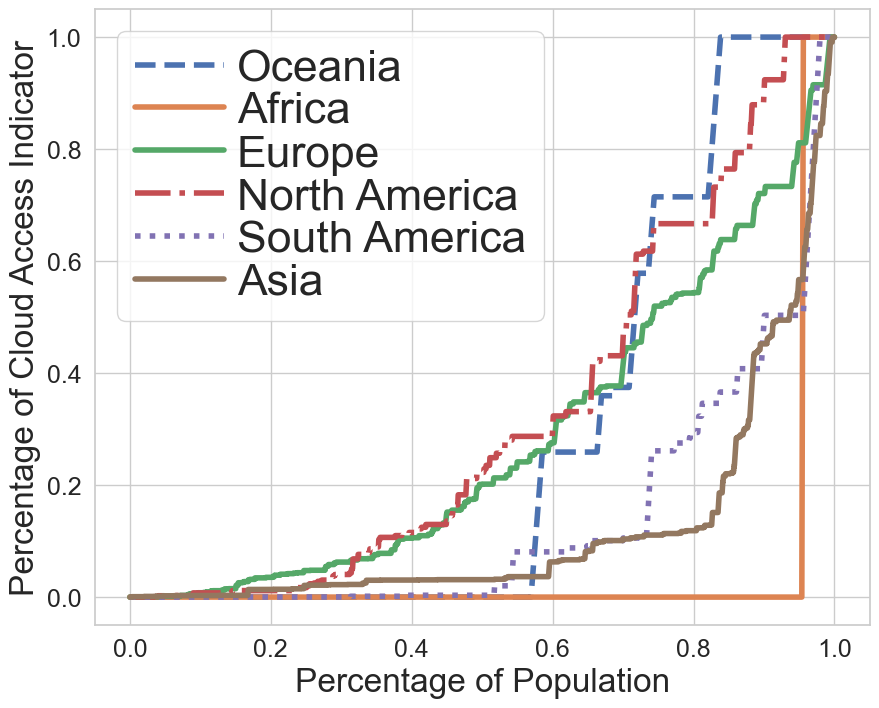

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


oc: 0.5243787301304647
af: 0.8166471361330803


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


eu: 0.38541311995557825


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


na: 0.5081551880613702


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid


sa: 0.6901220857356303


/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


as: 0.72252778114744


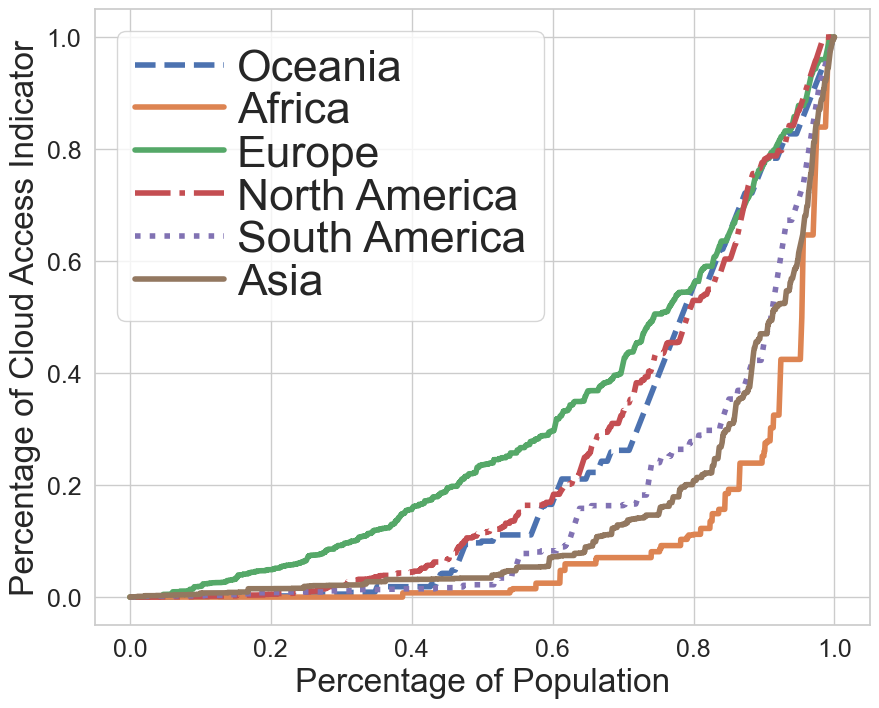

In [88]:
datacenters = loadDatacenters()
region_locations = [d.location for d in datacenters if d.region()]
local_locations = [d.location for d in datacenters if d.local]
non_edge_names = [d.name for d in datacenters if not d.edge]
edge_locations = [d.location for d in datacenters if d.edge and not d.name in non_edge_names]
points = region_locations + local_locations + edge_locations

distance_threshold = 88

fig, ax = plt.subplots(figsize=(10, 8))
for region in continents:
    lights_pop_gdf = lights_pop_gdf_per_continent[region]
    df_with_distances = addMinDistances(lights_pop_gdf, region_locations)
    ci_value = concentration_index_from_df(df_with_distances, distance_threshold, continentToName(region), ax, continentToStyle(region))
    print(f"{region}: {ci_value}")
ax.set_xlabel('Percentage of Population', size=24)
ax.set_ylabel('Percentage of Cloud Access Indicator', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="32",
    loc="upper left",
)
fig.savefig('images/global_region_concentration.png', bbox_inches='tight', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
for region in continents:
    lights_pop_gdf = lights_pop_gdf_per_continent[region]
    df_with_distances = addMinDistances(lights_pop_gdf, points)
    ci_value = concentration_index_from_df(df_with_distances, distance_threshold, continentToName(region), ax, continentToStyle(region))
    print(f"{region}: {ci_value}")
ax.set_xlabel('Percentage of Population', size=24)
ax.set_ylabel('Percentage of Cloud Access Indicator', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="32",
    loc="upper left",
)
fig.savefig('images/global_edge_concentration.png', bbox_inches='tight', dpi=300)
plt.show()

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/Users/noahmartin/miniforge3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

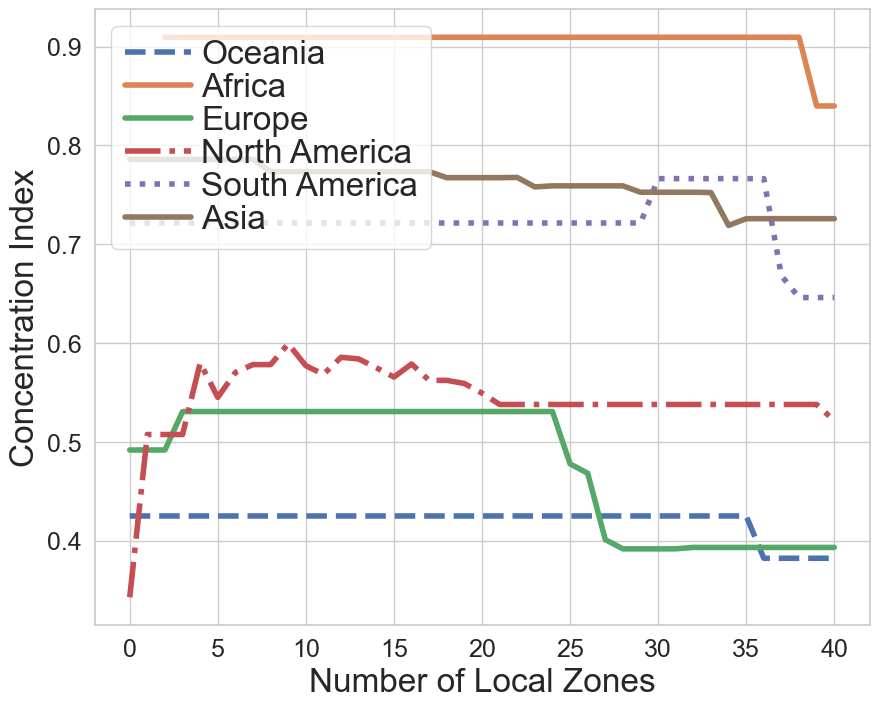

In [90]:
datacenters = loadDatacenters()
datacenters = [d for d in datacenters if d.dateTime() != None]
datacenters.sort(key=lambda x: x.dateTime())
start_index = 0
for d in datacenters:
    if d.local:
        break
    else:
        start_index += 1

fig, ax = plt.subplots(figsize=(10, 8))
for region in continents:
    concentration_indecies = []
    lights_pop_gdf = lights_pop_gdf_per_continent[region]
    for i in range(start_index, len(datacenters)+1):
        points = [d.location for d in datacenters[0:i]]
        df_with_distances = addMinDistances(lights_pop_gdf, points)
        concentration_indecies.append(concentration_index_from_df(df_with_distances, 88))
    ax.plot(np.arange(len(concentration_indecies)), concentration_indecies, linewidth=4, label=continentToName(region), linestyle=continentToStyle(region))
ax.set_xlabel('Number of Local Zones', size=24)
ax.set_ylabel('Concentration Index', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="24",
    loc="upper left",
)
fig.savefig('images/ci_new_locations.png', bbox_inches='tight', dpi=300)
plt.show()

## Optimal Cities

In [94]:
%pip install geonamescache

def total_poppulation(df_with_distances):
    df_with_distances['is_close'] = [min(d) < 88 for d in df_with_distances.distances]
    population = df_with_distances[df_with_distances['is_close'] == True]['Total Population']
    return sum(population)

def ci_with_distances(df_with_distances):
    population = df_with_distances['Total Population']
    income = df_with_distances[income_key]
    health_indicator = [sum([fast_concentration_health(d, 88)for d in distances])*p for (distances, p) in zip(df_with_distances['distances'], population)]

    ci_points = [[a[0], a[1], a[2]] for a in list(zip(population, income, health_indicator)) if not math.isnan(a[1])]
    ci_points = sorted(ci_points, key=lambda x:x[1])
    x = np.cumsum([p[0] for p in ci_points])
    y = np.cumsum([p[2] for p in ci_points])
    if x[-1] == 0:
        return None
    if y[-1] == 0:
        return None
    x = x / x[-1]
    y = y / y[-1]
    return concentration_index(x, y)

import geonamescache
gc = geonamescache.GeonamesCache()
cities = [city for city in gc.get_cities().values() if city['countrycode'] == 'US']
cities = sorted(cities, key=lambda x: x['population'], reverse=True)

def cityToPoint(city):
    return Point(city['longitude'], city['latitude'])

datacenters = [d for d in loadDatacenters() if d.local or d.region()]
us_locations = []
for d in datacenters:
    name = d.name
    if type(name) is dict:
        name = name['name']
    location = geolocator.geocode(name)
    if location and "United States" in location.address:
        us_locations.append(location)

def isFarEnough(p, prev_points):
    unit_sphere_to_km = 6371
    lat = np.deg2rad([c.y for c in prev_points])
    lng = np.deg2rad([c.x for c in prev_points])
    locations = pd.DataFrame(list(zip(lat, lng)), columns = ['lat', 'lng'])

    bt = BallTree(locations[['lat', 'lng']].values, metric='haversine')

    lat = np.deg2rad([p.y])
    lng = np.deg2rad([p.x])
    locations = pd.DataFrame(list(zip(lat, lng)), columns = ['lat', 'lng'])
    dist, idx = bt.query(locations[['lat', 'lng']].values, k=1)
    return dist[0][0] * unit_sphere_to_km > 88


population_indecies = []
populations = []
used_points = []
used_cities = []
for city in cities[0:200]:
    point = cityToPoint(city)
    if len(used_points) == 0 or isFarEnough(point, used_points):
        used_points.append(point)
        df_with_distances = addMinDistances(merged_geo_df, [point])
        ci_value = ci_with_distances(df_with_distances)
        if ci_value:
            population = total_poppulation(df_with_distances)
            populations.append(population)
            population_indecies.append(ci_value)
            used_cities.append(city)

aws_populations = []
aws_indecies = []
for location in us_locations:
    point = Point(location.longitude, location.latitude)
    df_with_distances = addMinDistances(merged_geo_df, [point])
    population = total_poppulation(df_with_distances)
    ci_value = ci_with_distances(df_with_distances)
    aws_populations.append(population)
    aws_indecies.append(ci_value)

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


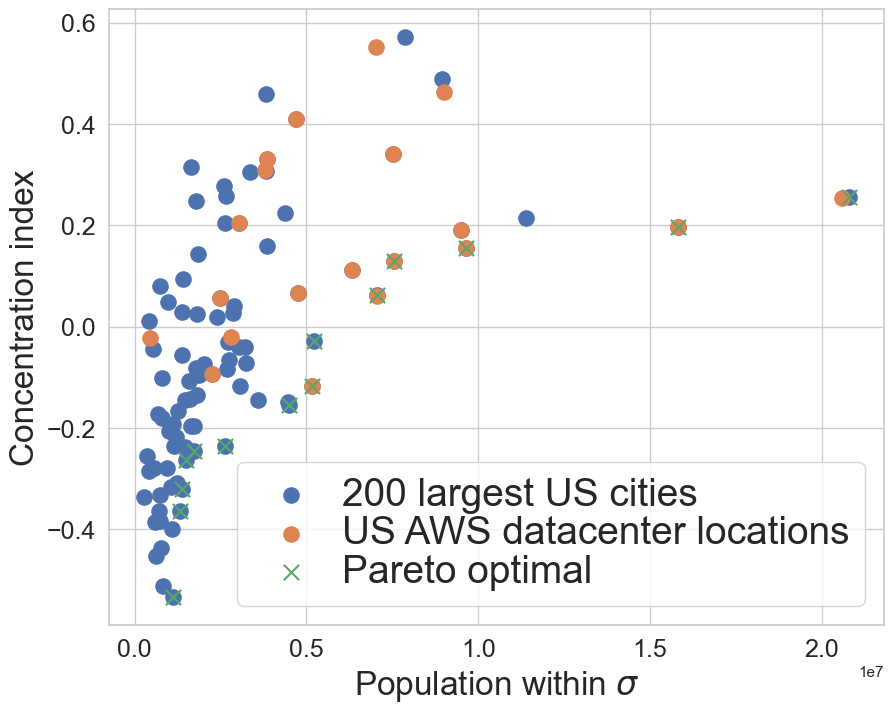

In [97]:
%pip install paretoset

from paretoset import paretoset

cities_df = pd.DataFrame(
    {
        "population": populations,
        "ci": population_indecies,
    }
)
used_cities_df = pd.DataFrame({
    "cities": used_cities,
})
mask = paretoset(cities_df, sense=["max", "min"])
optimal_cities = cities_df[mask]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(populations, population_indecies, label='200 largest US cities', s=120)
ax.scatter(aws_populations, aws_indecies, label='US AWS datacenter locations', s=120)
ax.scatter(optimal_cities.population, optimal_cities.ci, label='Pareto optimal', s=120, marker='x')
ax.set_xlabel('Population within $\sigma$', size=24)
ax.set_ylabel('Concentration index', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc="lower right",
)
fig.savefig('images/cities_plot.png', bbox_inches='tight', dpi=300)

# Starlink Concentraion Index

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = inputDF.geometry.centroid
/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_79771/3865222885.

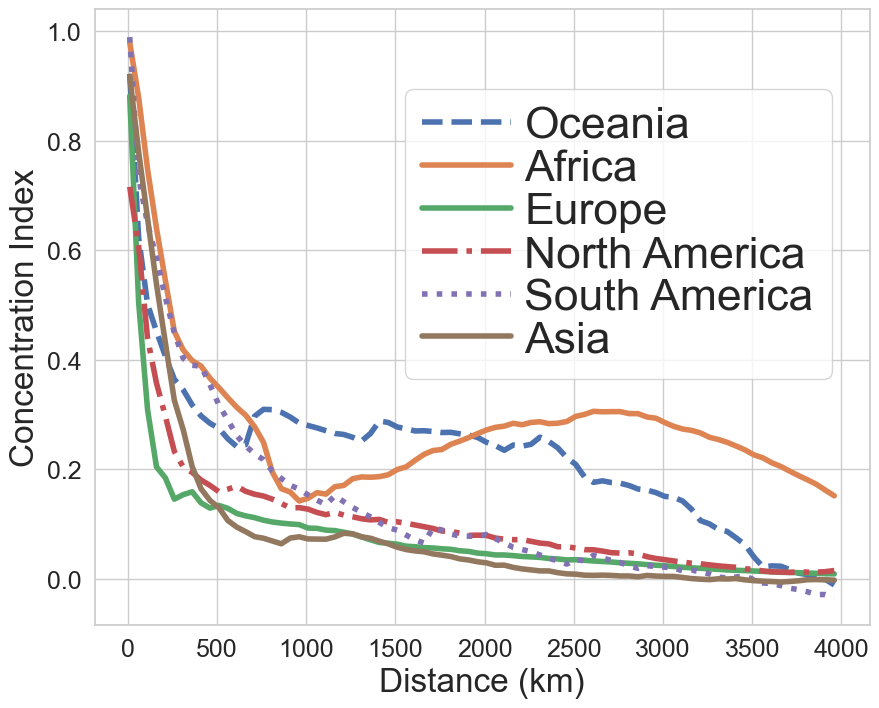

In [101]:
datacenters = loadDatacenters()
points = [d.location for d in datacenters]

fig, ax = plt.subplots(figsize=(10, 8))
for region in continents:
    concentration_indecies = []
    distances = []
    lights_pop_gdf = lights_pop_gdf_per_continent[region]
    df_with_distances = addMinDistances(lights_pop_gdf, points)
    for i in range(10, 4000, 50):
        concentration_indecies.append(concentration_index_from_df(df_with_distances, i))
        distances.append(i)
    ax.plot(distances, concentration_indecies, linewidth=4, label=continentToName(region), linestyle=continentToStyle(region))
ax.set_xlabel('Distance (km)', size=24)
ax.set_ylabel('Concentration Index', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="32",
    loc=(0.4, 0.4),
)
fig.savefig('images/global_concentration_leo.png', bbox_inches='tight', dpi=300)
plt.show()